In [1]:
import torch
from torch import nn
from timeit import default_timer as timer

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get Data

In [2]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
img_path = data_path / "pizza_steak_sushi"

if img_path.is_dir():
    print(f"{img_path} directory already exist... skipping downloading...")
else:
    print(f"{img_path} does not exist, creating one...")
    img_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip") 
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip Pizza, Steak, Sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(img_path)

data\pizza_steak_sushi directory already exist... skipping downloading...
Unzipping pizza, steak, sushi data...


# 2. Data preparation and data exploration 

In [3]:
import os

def get_data(dir_path):
    """Go through dir_path, returning it's contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} derictiris and {len(filenames)} images in '{dirpath}'.")

get_data(img_path)

There are 2 derictiris and 0 images in 'data\pizza_steak_sushi'.
There are 3 derictiris and 0 images in 'data\pizza_steak_sushi\test'.
There are 1 derictiris and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 derictiris and 2 images in 'data\pizza_steak_sushi\test\pizza\.ipynb_checkpoints'.
There are 0 derictiris and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 derictiris and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 derictiris and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 derictiris and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 derictiris and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 derictiris and 72 images in 'data\pizza_steak_sushi\train\sushi'.


## 2.1 Setup Train and test path

In [4]:
train_dir = img_path / "train"
test_dir = img_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2.2 Visualizing and image

1. Get all of the images path
2. Pick a rundom img path
3. Get img class name
4. Open img with Puthon's Pill (pillow
5. Show the img and print metadata 

Random Image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image Class: sushi
Image height: 408
Image width: 512


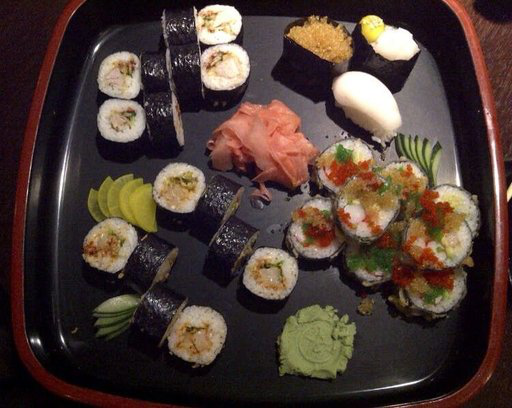

In [5]:
import random
from PIL import Image

#random.seed(42)

# 1. Get all the Img path
img_path_list = list(img_path.glob("*/*/*.jpg"))

# 2. Pick rundom img path
random_img_path = random.choice(img_path_list)

# 3. Get Img class 
img_class = random_img_path.parent.stem

# 4. Open Img
img = Image.open(random_img_path)

# 5. Print Metadata
print(f"Random Image path: {random_img_path}")
print(f"Image Class: {img_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [6]:
# Visualizing Image with Matplotlib
import matplotlib.pyplot as plt
import numpy as np

array([[[33, 13, 15],
        [30, 10, 12],
        [30, 10, 12],
        ...,
        [23, 14, 19],
        [21, 12, 17],
        [20, 11, 16]],

       [[35, 15, 17],
        [32, 12, 14],
        [31, 11, 13],
        ...,
        [21, 12, 17],
        [19, 10, 15],
        [19, 10, 15]],

       [[35, 15, 17],
        [32, 12, 14],
        [31, 11, 13],
        ...,
        [19, 10, 15],
        [18,  9, 14],
        [18,  9, 14]],

       ...,

       [[11,  6, 12],
        [11,  6, 12],
        [11,  6, 12],
        ...,
        [34, 18, 18],
        [33, 19, 18],
        [31, 17, 17]],

       [[ 8,  3,  9],
        [ 9,  4, 10],
        [ 9,  4, 10],
        ...,
        [36, 20, 20],
        [32, 16, 16],
        [27, 11, 11]],

       [[ 4,  0,  5],
        [ 5,  0,  6],
        [ 6,  1,  7],
        ...,
        [36, 21, 18],
        [32, 16, 16],
        [25,  9,  9]]], dtype=uint8)


(-0.5, 511.5, 407.5, -0.5)

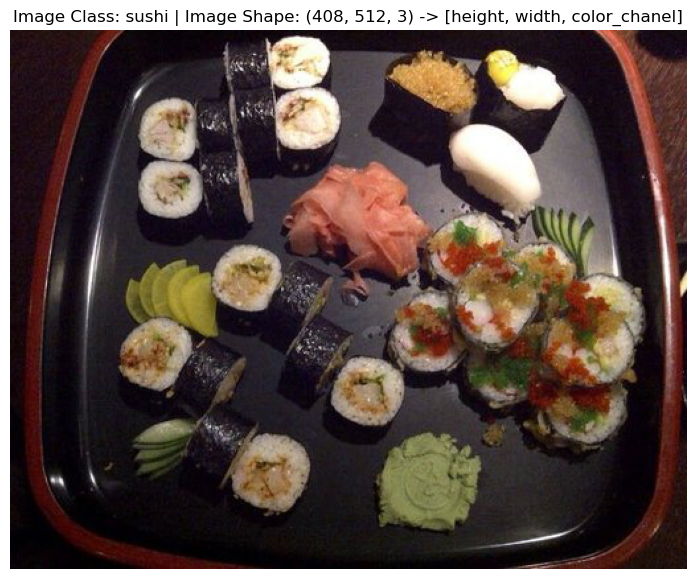

In [7]:
img_array = np.asarray(Image.open(random_img_path))
print(repr(img_array))
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image Class: {img_class} | Image Shape: {img_array.shape} -> [height, width, color_chanel]")
plt.axis(False)

# 3 Transforming data with `torchvision.transforms`

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [9]:
data_transform = transforms.Compose([ 
    # Resize image
    transforms.Resize(size=(64, 64)),
    # Flip the image randomly, horizontal
    transforms.RandomHorizontalFlip(p=0.5), # 50% of all images will be flip horisontaly
    # Turn image in to Tensor
    transforms.ToTensor()
])

data_transform(img).shape # (Ch,H,W)

torch.Size([3, 64, 64])

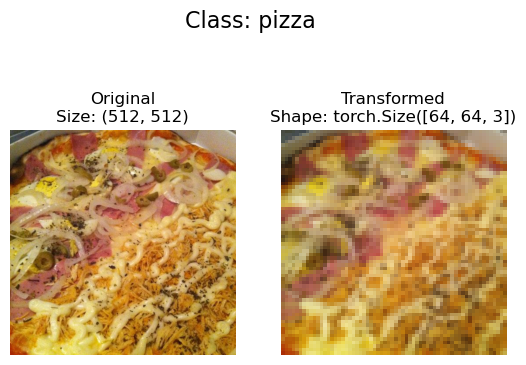

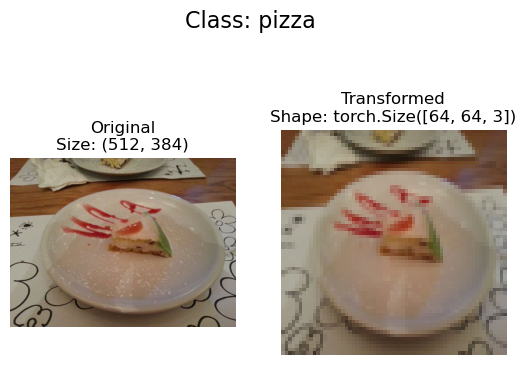

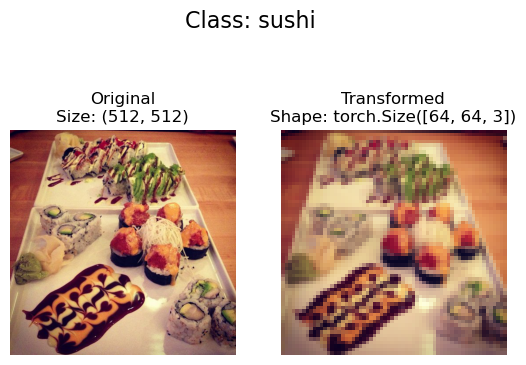

In [10]:
def plot_tranformed_img(image_path: list, transform, n=3, seed=None):
    """Take random img from a path of images and transform/loaded them, then plot the original vs transformed version"""
    if seed:
        random.seed(seed)
    random_img_path = random.sample(image_path, k=n)
    for img_path in random_img_path:
        with Image.open(img_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0) # shape if image need to be change to matplotlib from (Ch,H,W) -> (H,W,CH) 
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {img_path.parent.stem}", fontsize=16)

plot_tranformed_img(image_path=img_path_list, 
                    transform=data_transform,
                    n=3,
                    seed=None
                   )

# 4. Option 1. Load image data using `ImageFolder`
* torchvision.datasets.ImageFolder

In [11]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transfrom for data 
                                  target_transform=None) # transform for label/targer

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 77
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get class names as List
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Get class names as dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the len of our dataset
len(train_data), len(test_data)

(225, 77)

In [15]:
# Index on the train_data Dataset to get a single image and label
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Dataset: {img.dtype}")
print(f"Label: {label}")
print(f"Label datatype: {type(label)}") 

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

In [17]:
label

0

In [18]:
class_names[label]

'pizza'

In [19]:
# Rearange the order dimetions
img_permute = img.permute(1, 2, 0)
img_permute.shape

torch.Size([64, 64, 3])

(-0.5, 63.5, 63.5, -0.5)

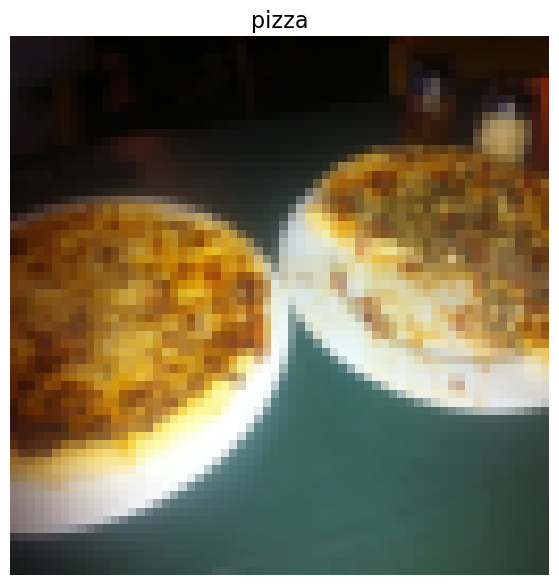

In [20]:
# plot image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=16)
plt.axis(False)

In [21]:
os.cpu_count()

16

In [22]:
# Turn data in DataLoader 
train_dataloder = DataLoader(dataset=train_data, batch_size=9, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=9, num_workers=os.cpu_count(), shuffle=True)

len(train_dataloder), len(test_dataloader)

(25, 9)

In [23]:
img, label = next(iter(train_dataloder))
print(f"Image shape: {img.shape} -> [batch, color_channels, H, W]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([9, 3, 64, 64]) -> [batch, color_channels, H, W]
Label shape: torch.Size([9])


# 5. Option 2 Loading Image data with Custom Dataset 

* Can create a DataSet out of almost anything
* Not limited with PyTorch pre-build functions  

In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

## 5.1 Create a helper function to get Class names

1. Get the class names using `os.scandir()`, to traverse a terget directory
2. Raise an error if class names aren't found
3. Turn class names in to a dict and a list and return them  

In [25]:
# Setup path for a targetn directiory
target_directory = train_dir
print(f"Target Directiory: {train_dir}")

# Get the class names from traget dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Directiory: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[list[str], dict[str, int]]:
    """Find the class folder names in a target directiory"""
    # 1. Get the class names  by scanning the traget directory
    classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

    # 2. Raise an error if class name could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any Classes in {directory}... please check file structure.")

    # 3. Create a dictionary of index labels 
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom Dataset to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory that we'd like to get data from) as well as a transform  if we'd like to transform our data.
3. Create a several attributes:
    * paths - paths our images
    * transform - the tranfrom we'd like to use
    * classes - a list of target classes
    * class_to_idx - a dictionary of the target classes mapped to integer labels
4. Create a function to `load_images()`
5. Overwrite the `__len__()` method to return the lenght of dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [27]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, 
                 transform=None):
        # Creat class atributs
        ## Get all images paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        ## Setup transform
        self.transform = transform
        ## Create classes and classes_to_idx attibutes 
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and return it."""
        image_paths = self.paths[index]
        return Image.open(image_paths)

    # Overwrit __len__()
    def __len__(self) -> int:
        "Returns the total numbers of samples."
        return len(self.paths)

    # Overwrite __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Return one sampole of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        ## Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [28]:
# Create transform 
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
]) 

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [29]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms) 
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1d85424d700>,
 <__main__.ImageFolderCustom at 0x1d8553d04a0>)

In [30]:
len(train_data), len(train_data_custom)

(225, 225)

In [31]:
len(test_data), len(test_data_custom)

(77, 75)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [33]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

## 5.3 Create a function to display random images

1. Take in a `Data Set`
2. Get a list of ramdom sample index from target dataset 

In [34]:
random.sample(range(len(train_data_custom)), k=10)

[98, 1, 181, 216, 224, 78, 35, 26, 69, 48]

In [35]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shoudn't be larger than 10, setting to 10 and remove dysplay_shape")

    if seed:
        random.seed(seed)
        
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))
    
    # loop through random indexes and plot them with matplotlib
    for i, target_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]
        image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(image_adjust)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {image_adjust.shape}"
        plt.title(title)

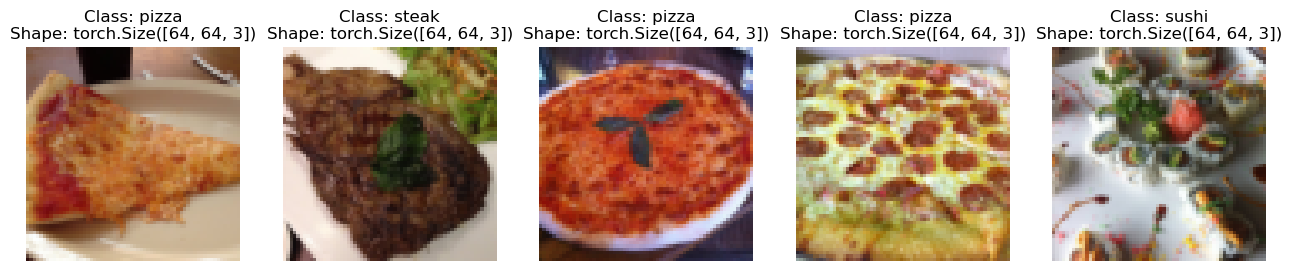

In [36]:
display_random_images(train_data,
                     n=5,
                     classes=class_names,
                     seed=None)

For display purposes, n shoudn't be larger than 10, setting to 10 and remove dysplay_shape


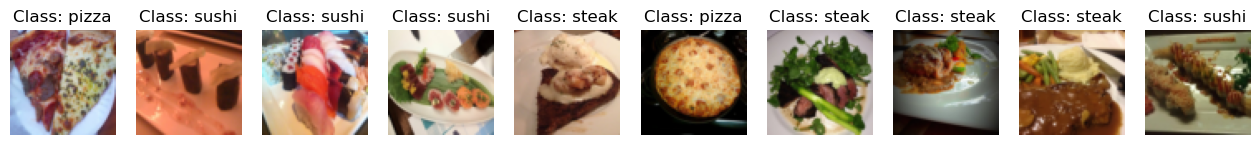

In [37]:
display_random_images(train_data_custom, 
                      n=20,
                      classes=class_names,
                      seed=None)

## 5.4 Turn castom loder into Dataloader

In [38]:
train_dataloder_custom = DataLoader(dataset=train_data_custom, batch_size=9, shuffle=True, num_workers=0)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=9, num_workers=0)

train_dataloder_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1d84d98d460>,
 <torch.utils.data.dataloader.DataLoader at 0x1d8542e4890>)

In [39]:
img_custom, label_castom = next(iter(train_dataloder_custom))
img_custom.shape, label_castom.shape

(torch.Size([9, 3, 64, 64]), torch.Size([9]))

# 6. Other forms of transforms (data augmentation)

In [40]:
# Tirvailaugmaent
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                    transforms.ToTensor()])

In [41]:
img_path

WindowsPath('data/pizza_steak_sushi')

In [42]:
image_path_list = list(img_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

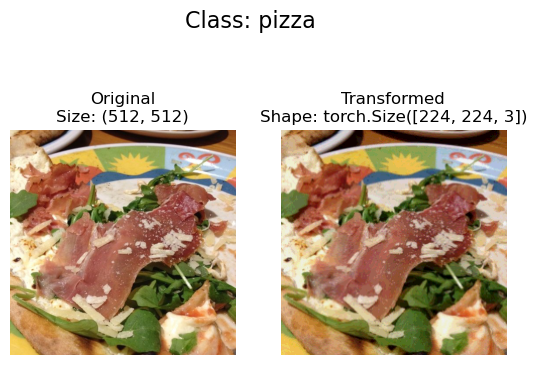

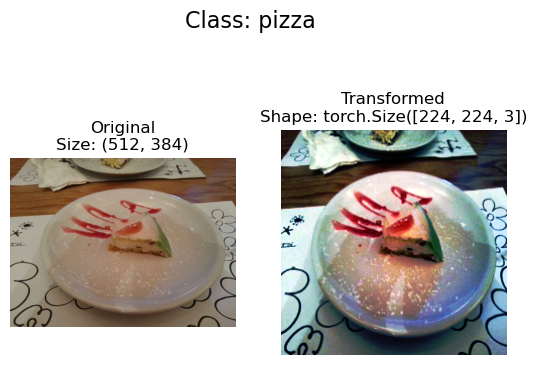

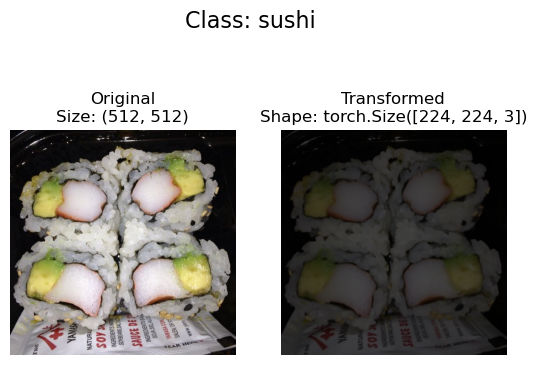

In [43]:
plot_tranformed_img(image_path=img_path_list, transform=train_transform, n=3, seed=None)

# 7. Model 0: TinyVGG without data augmentation

## 7.1 Createnig transforms and loading data for Model_0

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [45]:
simple_train_data = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform,
                                         target_transform=None)

simple_test_data = datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

simple_test_data, simple_train_data

(Dataset ImageFolder
     Number of datapoints: 77
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [46]:
# Turn datasets into DataLoader
train_dataloder_simple = DataLoader(dataset=simple_train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(dataset=simple_test_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())

## 7.2 Create TinyVGG Model_0

In [47]:
class TinyVGG(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidde_layers: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidde_layers, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidde_layers, out_channels=hidde_layers, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidde_layers, out_channels=hidde_layers, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidde_layers, out_channels=hidde_layers, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.clasiffier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidde_layers*13*13, # RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3), Output shepe of conv_block_2: torch.Size([32, 10, 13, 13]) 10*13*13=1690 in this case our hiddin_layers = 10, so we need to * hidden_layers on 13*13.
                     out_features=output_shape)
        )
        
    def forward(self, x):
       # x = self.conv_block_1(x)
       #print(f"Output shepe of conv_block_1: {x.shape}")
       # x = self.conv_block_2(x)
       #print(f"Output shepe of conv_block_2: {x.shape}")
       # x = self.clasiffier(x)
       #print(f"Output shepe of clasiffier: {x.shape}")
       #return x
       return self.clasiffier(self.conv_block_2(self.conv_block_1(x))) # better and faster option than just return  x 

In [48]:
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidde_layers=10,
                  output_shape=len(class_names)).to(device)

model_0                

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasiffier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 7.3 Try a forward pass on a lingle image (to test the model)

In [49]:
# Get a single image_batch, label_batsh
image_batch, label_batch = next(iter(train_dataloder_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
model_0(image_batch)

tensor([[-0.0496,  0.0150,  0.0309],
        [-0.0471,  0.0135,  0.0315],
        [-0.0477,  0.0159,  0.0309],
        [-0.0474,  0.0167,  0.0326],
        [-0.0477,  0.0155,  0.0296],
        [-0.0479,  0.0146,  0.0305],
        [-0.0498,  0.0184,  0.0293],
        [-0.0443,  0.0167,  0.0289],
        [-0.0484,  0.0142,  0.0335],
        [-0.0474,  0.0161,  0.0317],
        [-0.0498,  0.0138,  0.0304],
        [-0.0496,  0.0171,  0.0305],
        [-0.0492,  0.0172,  0.0303],
        [-0.0491,  0.0151,  0.0315],
        [-0.0473,  0.0164,  0.0299],
        [-0.0468,  0.0151,  0.0266],
        [-0.0489,  0.0159,  0.0316],
        [-0.0467,  0.0134,  0.0313],
        [-0.0494,  0.0154,  0.0299],
        [-0.0469,  0.0154,  0.0339],
        [-0.0506,  0.0165,  0.0292],
        [-0.0514,  0.0173,  0.0305],
        [-0.0458,  0.0139,  0.0332],
        [-0.0494,  0.0160,  0.0313],
        [-0.0497,  0.0175,  0.0299],
        [-0.0492,  0.0180,  0.0304],
        [-0.0472,  0.0108,  0.0295],
 

## 7.4 Use `torchinfo` to get an idea of theshape of our model

In [51]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

In [52]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create a train and test functions 

In [53]:
def acc_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [1]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
    
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return train_loss, train_acc
    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.1f}")    

NameError: name 'nn' is not defined

In [2]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module):

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    
    return test_loss, test_acc

NameError: name 'nn' is not defined

In [57]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    # Create empty dictionary for results.
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloder,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, 
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn)
        print(f"Eprch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.1f} % | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.1f} % ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

## 7.6 Train Model_0

In [58]:
model_0 = TinyVGG(input_shape=3, hidde_layers=10, output_shape=len(train_data.classes)).to(device)
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [59]:
strat_time = timer()
model_0_result = train(model=model_0,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       train_dataloader=train_dataloder_simple,
                       test_dataloader=test_dataloader_simple)
end_time = timer()
print(f"Total time: {end_time - strat_time:.1f} seconds.")

Eprch: 0 | Train Loss: 1.11 | Train Acc: 0.3 % | Test Loss: 1.10 | Test Acc: 0.3 % 
Eprch: 1 | Train Loss: 1.09 | Train Acc: 0.5 % | Test Loss: 1.10 | Test Acc: 0.3 % 
Eprch: 2 | Train Loss: 1.06 | Train Acc: 0.5 % | Test Loss: 1.07 | Test Acc: 0.3 % 
Eprch: 3 | Train Loss: 0.98 | Train Acc: 0.5 % | Test Loss: 1.00 | Test Acc: 0.3 % 
Eprch: 4 | Train Loss: 0.91 | Train Acc: 0.6 % | Test Loss: 0.91 | Test Acc: 0.6 % 
Total time: 118.0 seconds.


In [60]:
model_0_result

{'train_loss': [1.113461880683899,
  1.09252685546875,
  1.0562493872642518,
  0.9767352271080018,
  0.9099451375007629],
 'train_acc': [0.2888888888888889,
  0.45333333333333337,
  0.5244444444444444,
  0.5111111111111111,
  0.5555555555555557],
 'test_loss': [1.0993630091349285,
  1.096921722094218,
  1.0681286255518596,
  0.9994053840637207,
  0.9133784572283427],
 'test_acc': [0.28125,
  0.3125,
  0.3229166666666667,
  0.33253205128205127,
  0.6145833333333334]}

## 7.8 Plot loss curves of MOdel_0

**Loss Curves** is a way to tracking your model's progress over time.

In [61]:
def plot_loss_cruve(results: Dict[str, List[float]]):
    # Get loss values
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]
    # Get Acc values
    train_acc = results["train_acc"]
    test_acc = results["test_acc"]
    # Figure put how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Setup Plot
    plt.figure(figsize=(15, 7))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, test_loss, label="Test Loss")
    plt.title("Loss")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, test_acc, label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    

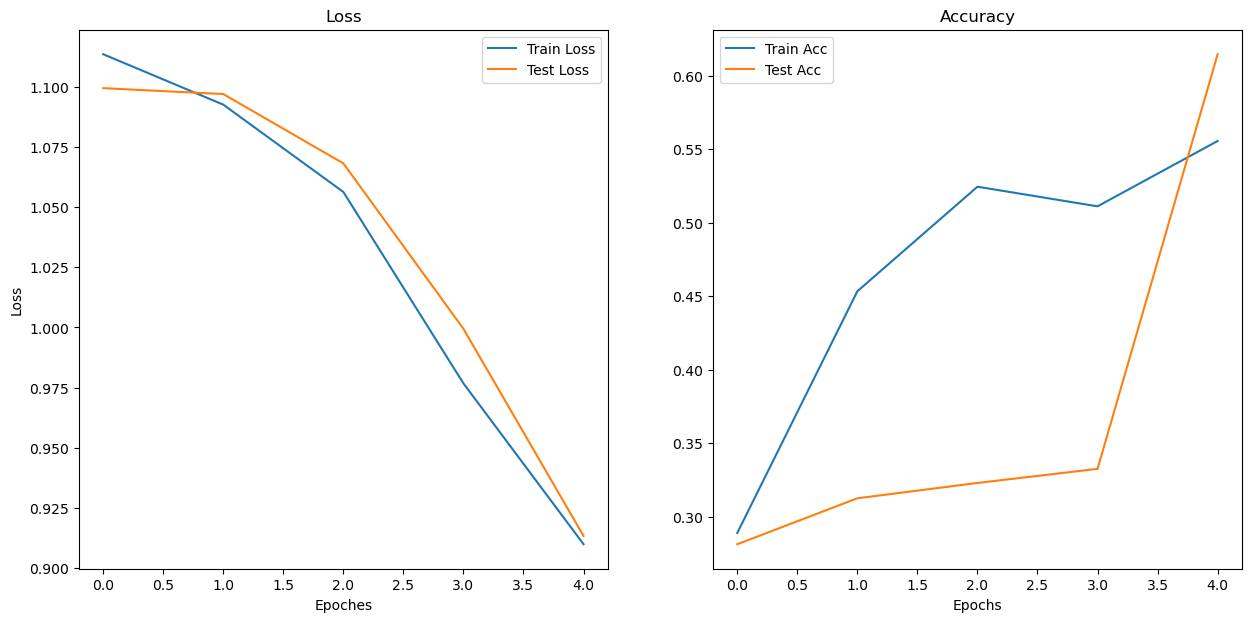

In [62]:
plot_loss_cruve(model_0_result)

# 8. Model_1: TinyVGG with Data Aurgmentation

## 8.1 Create transforms with data aurgmentation

In [63]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

## 8.2 Create train and test `Dataset` and `DataLoader` with data aurgmentation

In [64]:
train_data_aurgmented = datasets.ImageFolder(root=train_dir, transform=train_transform_trivial, target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=test_transforms_simple, target_transform=None)

In [65]:
train_dataloader_argumented = DataLoader(dataset=train_data_aurgmented, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=32, shuffle=False, num_workers=os.cpu_count())

In [66]:
# Train Model_1
model_1 = TinyVGG(input_shape=3, hidde_layers=10, output_shape=len(train_data_aurgmented.classes)).to(device)
optimizer_aurgmented = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clasiffier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [67]:
start_time = timer()

model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader_argumented,
                       test_dataloader=test_dataloader_simple,
                       loss_fn=loss_fn,
                       optimizer=optimizer_aurgmented,
                       epochs=5)
and_time = timer()
print(f"Total time: {end_time-strat_time:.1f} seconds") 

Eprch: 0 | Train Loss: 1.10 | Train Acc: 0.3 % | Test Loss: 1.10 | Test Acc: 0.3 % 
Eprch: 1 | Train Loss: 1.09 | Train Acc: 0.4 % | Test Loss: 1.08 | Test Acc: 0.4 % 
Eprch: 2 | Train Loss: 1.00 | Train Acc: 0.5 % | Test Loss: 1.06 | Test Acc: 0.4 % 
Eprch: 3 | Train Loss: 0.90 | Train Acc: 0.5 % | Test Loss: 1.06 | Test Acc: 0.4 % 
Eprch: 4 | Train Loss: 0.85 | Train Acc: 0.6 % | Test Loss: 0.95 | Test Acc: 0.4 % 
Total time: 118.0 seconds


## 8.3 Plot Model_1 results

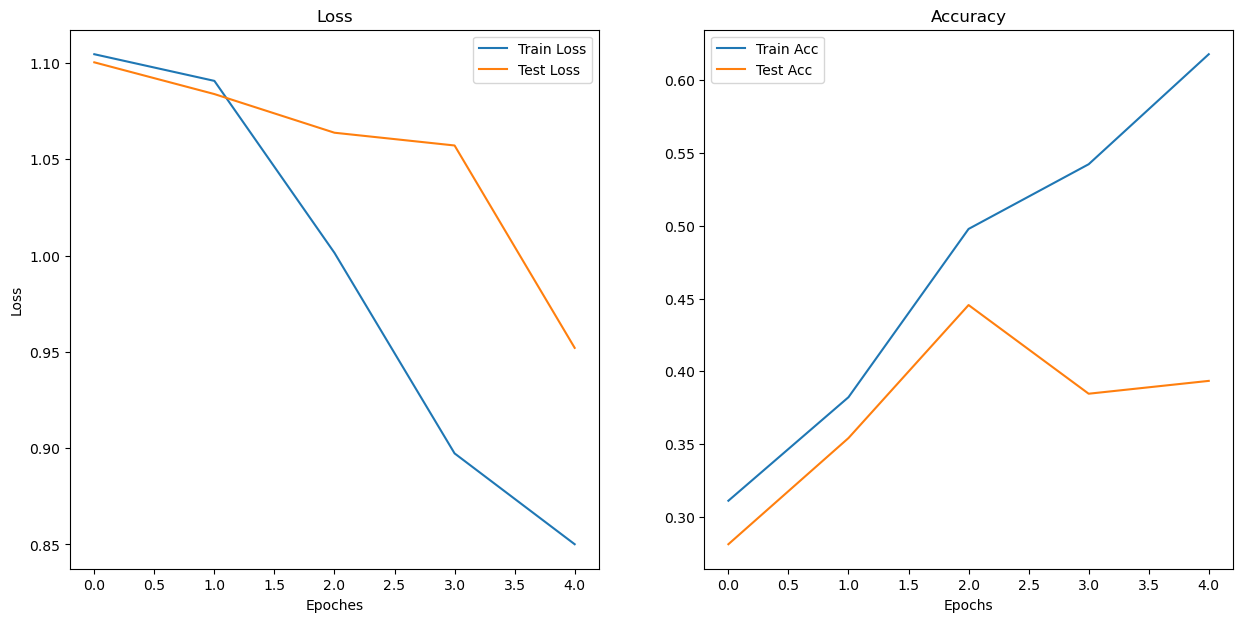

In [68]:
plot_loss_cruve(model_1_results)

# 9. Compare models results

In [69]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_result)
model_1_df = pd.DataFrame(model_1_results)
model_0_df, model_1_df

(   train_loss  train_acc  test_loss  test_acc
 0    1.113462   0.288889   1.099363  0.281250
 1    1.092527   0.453333   1.096922  0.312500
 2    1.056249   0.524444   1.068129  0.322917
 3    0.976735   0.511111   0.999405  0.332532
 4    0.909945   0.555556   0.913378  0.614583,
    train_loss  train_acc  test_loss  test_acc
 0    1.104625   0.311111   1.100415  0.281250
 1    1.090776   0.382222   1.083927  0.354167
 2    1.001445   0.497778   1.063848  0.445513
 3    0.897290   0.542222   1.057224  0.384615
 4    0.850109   0.617778   0.952097  0.393429)

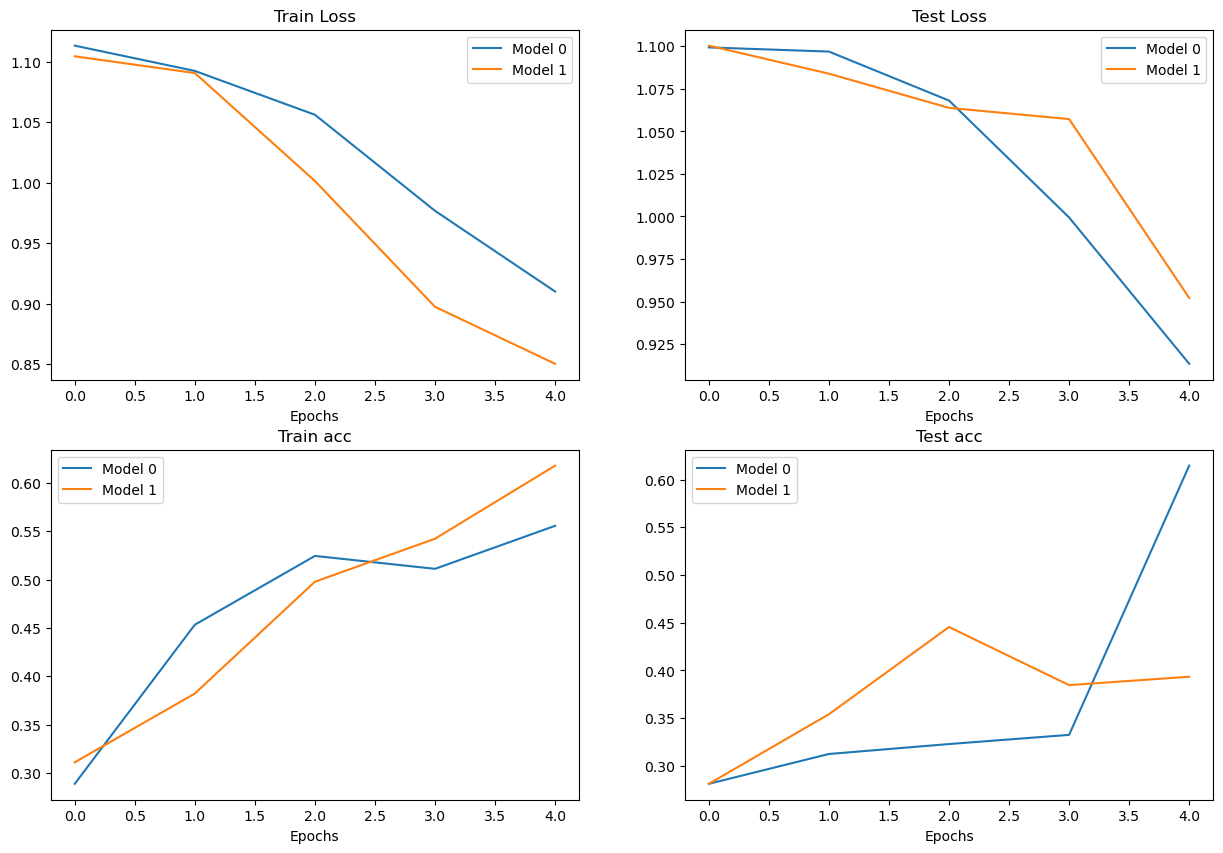

In [70]:
# Setup Plot
plt.figure(figsize=(15, 10))
epochs = range(len(model_0_df))
# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()
# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()
# Plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend()
# Plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()

# 10. Making a prediction on a custom image

In [71]:
#  Download a custom image
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}... ")
        f.write(request.content)
else:
    print(f"{custom_image_path} alredy exist.")

data\04-pizza-dad.jpeg alredy exist.


## 10.1 Read custom image in PyTorch 

In [72]:
import torchvision

# Read image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom Image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom Image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

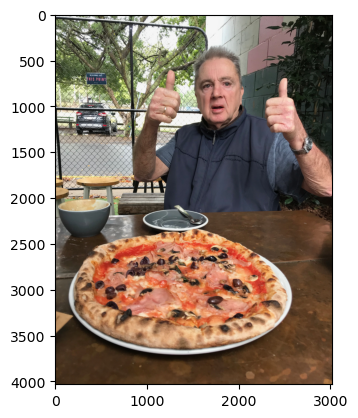

In [73]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

## 10.2 Making prediction on a custom image

In [74]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8)

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [75]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) # need devided image on 255 is giving tensor in range [0:1] 
custom_image.shape, custom_image

(torch.Size([3, 4032, 3024]),
 tensor([[[154., 173., 181.,  ...,  21.,  18.,  14.],
          [146., 165., 181.,  ...,  21.,  18.,  15.],
          [124., 146., 172.,  ...,  18.,  17.,  15.],
          ...,
          [ 72.,  59.,  45.,  ..., 152., 150., 148.],
          [ 64.,  55.,  41.,  ..., 150., 147., 144.],
          [ 64.,  60.,  46.,  ..., 149., 146., 143.]],
 
         [[171., 190., 193.,  ...,  22.,  19.,  15.],
          [163., 182., 193.,  ...,  22.,  19.,  16.],
          [141., 163., 184.,  ...,  19.,  18.,  16.],
          ...,
          [ 55.,  42.,  28.,  ..., 107., 104., 103.],
          [ 47.,  38.,  24.,  ..., 108., 104., 102.],
          [ 47.,  43.,  29.,  ..., 107., 104., 101.]],
 
         [[119., 138., 147.,  ...,  17.,  14.,  10.],
          [111., 130., 145.,  ...,  17.,  14.,  11.],
          [ 87., 111., 136.,  ...,  14.,  13.,  11.],
          ...,
          [ 35.,  22.,   8.,  ...,  52.,  52.,  48.],
          [ 27.,  18.,   4.,  ...,  50.,  49.,  44.],
 

In [76]:
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32)  / 255 # devided on 255 is giving tensor in range [0:1] 
custom_image.shape, custom_image

(torch.Size([3, 4032, 3024]),
 tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
          [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
          [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
          ...,
          [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
          [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
          [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],
 
         [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
          [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
          [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
          ...,
          [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
          [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
          [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],
 
         [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
          [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
          

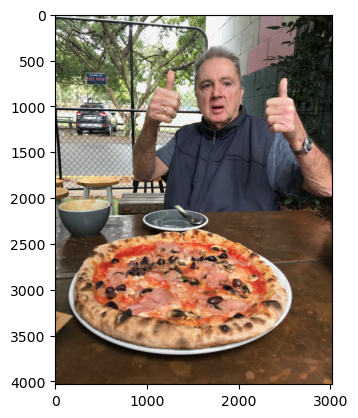

In [77]:
plt.imshow(custom_image.permute(1, 2, 0))

In [78]:
## 10.3 Create transform of custom image

In [79]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))])

In [80]:
custom_image_transfomed = custom_image_transform(custom_image)
print(f"Original image shape: {custom_image.shape}")
print(f"Transformed image shape: {custom_image_transfomed.shape}")

Original image shape: torch.Size([3, 4032, 3024])
Transformed image shape: torch.Size([3, 64, 64])


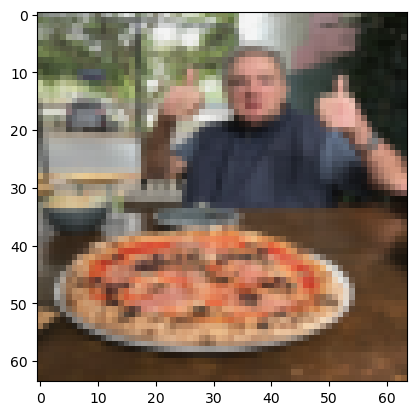

In [81]:
plt.imshow(custom_image_transfomed.permute(1, 2, 0))

In [82]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transfomed) # this will give an error: no betch size

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [83]:
custom_image_transfomed.shape, custom_image_transfomed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [84]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transfomed.unsqueeze(0))
custom_image_pred

# Note: o make predicion on a custom image:
# 1. Load the image and turn it in to tensor
# 2. Make shure that image was the same datatype as the model (torch.floa32)
# 3. Make shure that image was the same shape as the data model was trained on (3, 64, 64) with a batch size (1, 3, 64, 64)
# 4. Make shure that image was on the same device as our model

tensor([[ 0.1959, -0.6480, -0.0691]])

In [85]:
class_names

['pizza', 'steak', 'sushi']

## 10.3 Convert logits -> prediction probabilities -> prediction labels

In [86]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4551, 0.1957, 0.3492]])

In [87]:
# prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0])

In [88]:
class_names[custom_image_pred_label]

'pizza'

## 10. 4 Create a function putting custom image prediction together

In [131]:
def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        transform=None,
                        class_names=None
                       ):

    target_img = torchvision.io.read_image(image_path).type(torch.float32) / 255

    if transform:
        target_img = transform(target_img)

    model.eval()
    with torch.inference_mode():
        img_pred = model(target_img.unsqueeze(0))
    img_pred_probs = torch.softmax(img_pred, dim=1)
    img_pred_label = torch.argmax(img_pred_probs, dim=1)
    # img_pred_label = torch.argmax(torch.softmax(img_pred, dim=1), dim=1)

    # Plot the image alongside the prediction and prediction probabilities
    plt.imshow(target_img.squeeze(0).permute(1, 2, 0)) # remove batch dimention and rearrange shape to color channels last
    if class_names:
        title = f"Pred: {class_names[img_pred_label]} | Prob: {img_pred_probs.max().cpu():.2f}"
        plt.title(title)
    else:
        title = f"Pred: {img_pred_label}"
        plt.title(title)
    plt.axis(False)

In [92]:
custom_image_path

WindowsPath('data/04-pizza-dad.jpeg')

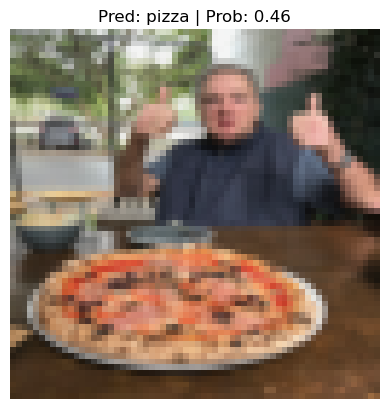

In [137]:
pred_and_plot_image(model=model_1, image_path=custom_image_path, transform=custom_image_transform, class_names=class_names)